In [1]:
import torch

In [2]:
torch.__version__

'2.2.2'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
x = torch.rand(5, 3).to(device)

In [5]:
x

tensor([[0.6261, 0.2135, 0.0300],
        [0.8664, 0.3494, 0.3394],
        [0.7853, 0.3666, 0.3911],
        [0.9165, 0.2989, 0.3054],
        [0.9545, 0.8552, 0.7846]])

# K-Means

In [6]:
import matplotlib.pyplot as plt

In [7]:
N = 100
x1 = torch.randn(N, 2)
x2 = torch.randn(N, 2) + torch.Tensor([3, 3])
x3 = torch.randn(N, 2) + torch.Tensor([-3, 3])

In [8]:
X = torch.cat([x1, x2, x3], dim=0)
print(X.shape)

torch.Size([300, 2])


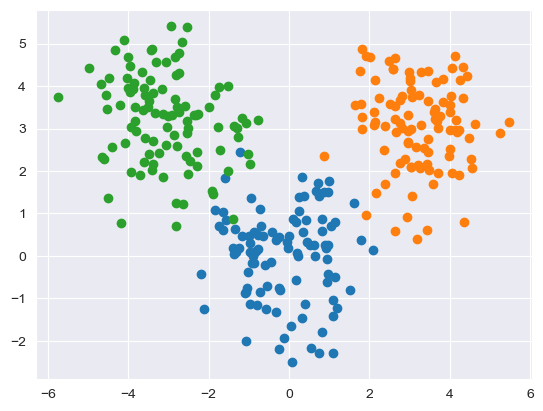

In [9]:
for i in range(3):
    plt.scatter(X[i*N:(i+1)*N, 0], X[i*N:(i+1)*N, 1])
plt.show()

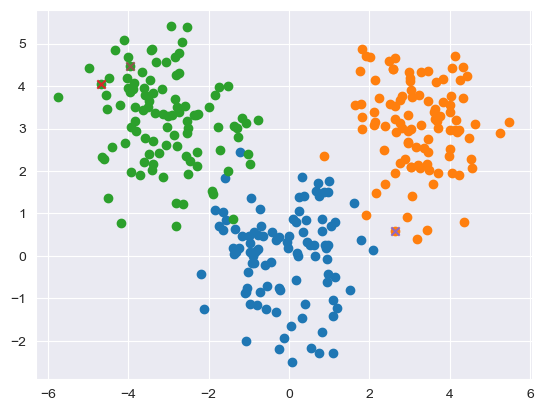

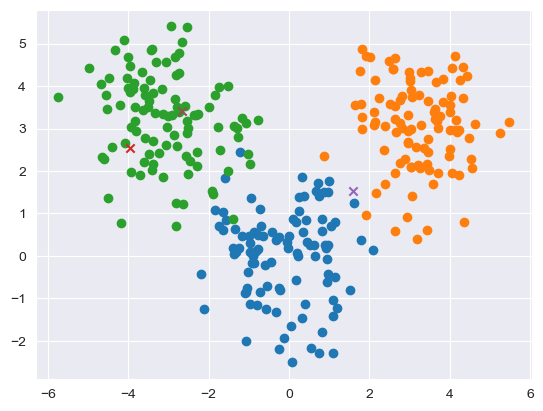

In [10]:
K = 3
centroids = X[torch.randperm(len(X))[:K]]
while True:
    D = torch.cdist(X, centroids)
    clusters = torch.argmin(D, dim=1)
    for i in range(3):
        plt.scatter(X[i*N:(i+1)*N, 0], X[i*N:(i+1)*N, 1])
    old_centroids = centroids.clone()
    for k in range(K):
        plt.scatter(centroids[k, 0], centroids[k, 1], marker='x')
        centroids[k] = X[clusters == k].mean(dim=0)
    change = torch.sum((centroids - old_centroids) ** 2)
    if change < 0.1:
        break
    plt.show()

In [11]:
import time
device = 'cpu'

N = 100000
x1 = torch.randn(N, 2)
x2 = torch.randn(N, 2) + torch.Tensor([3, 3])
x3 = torch.randn(N, 2) + torch.Tensor([-3, 3])
X = torch.cat([x1, x2, x3], dim=0).to(device)

t1 = time.time()
K = 3
centroids = X[torch.randperm(len(X))[:K]]
for _ in range(100):
    D = torch.cdist(X, centroids)
    clusters = torch.argmin(D, dim=1)
    for k in range(K):
        centroids[k] = X[clusters == k].mean(dim=0)
print(time.time() - t1)

2.114372968673706


# Auto differentiation

In [12]:
x = torch.tensor(3., requires_grad=True)
y = x**2 + 2*x + 1 
# y' = 2x + 2
y.backward()

In [13]:
x.grad # 2(3) + 2

tensor(8.)

# Regression

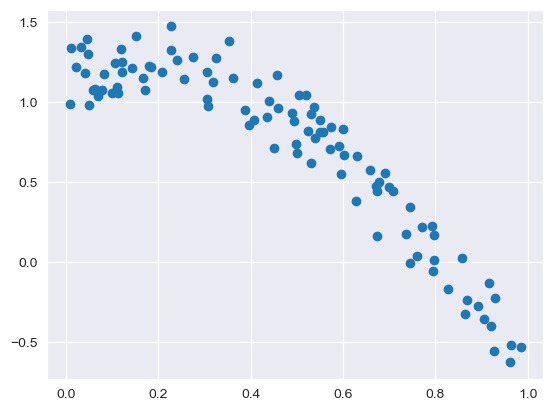

In [14]:
N = 100
x = torch.rand(N, 1)
y = torch.sin(3 * x + 1) + 0.5 * torch.rand(N, 1)
plt.scatter(x, y)

In [15]:
ones = torch.ones(N, 1)
X = torch.cat([x, ones], dim=1)

In [16]:
R = torch.inverse(X.T @ X) @ X.T @ y

In [17]:
x_ = torch.linspace(0, 1, 100).reshape(-1, 1)

In [18]:
y_ = x_ * R[0] + R[1]

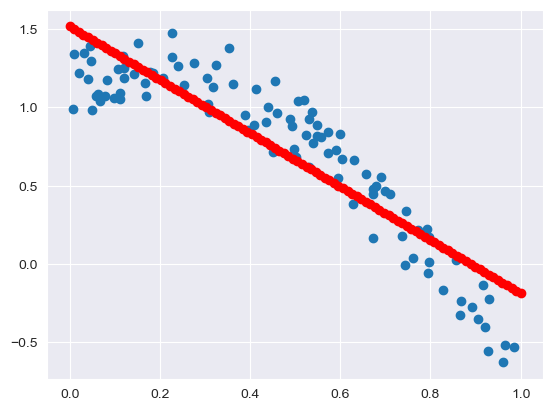

In [19]:
plt.scatter(x, y)
plt.scatter(x_, y_, color='r')
plt.show()

## Nonlinear

In [20]:
ones = torch.ones(N, 1)
X = torch.cat([x**2, x, ones], dim=1)

In [21]:
R = torch.inverse(X.T @ X) @ X.T @ y

In [22]:
y_ = x_**2 * R[0] + x_ * R[1] + R[2]

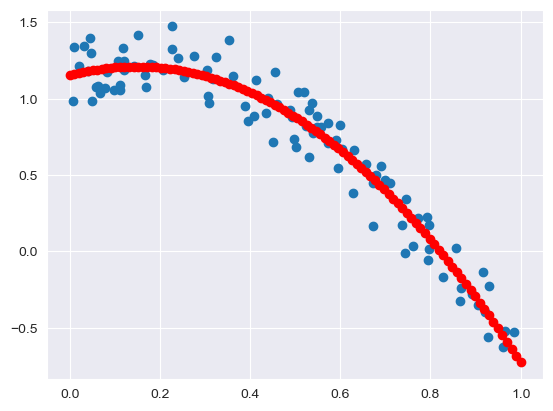

In [23]:
plt.scatter(x, y)
plt.scatter(x_, y_, color='r')
plt.show()

In [24]:
device = 'cpu'

N = 100000000
x = torch.rand(N, 1).to(device)
y = torch.sin(3 * x + 1) + 0.5 * torch.rand(N, 1).to(device)

t1 = time.time()
degree = 1
ones = torch.ones(N, 1).to(device)
X = torch.cat([x, ones], dim=1)
for i in range(2, degree + 1):
    X = torch.cat([x**i, X], dim=1)
R = torch.inverse(X.T @ X) @ X.T @ y
print(time.time() - t1)

1.4445927143096924


# MLP

In [25]:
from torch import nn

In [26]:
# [1] 32 16 [1]
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return self.fc3(x)

In [27]:
(1*32+32) + (32*16+16) + (16*1+1)

609

In [28]:
model = Regressor()

In [29]:
gen = iter(model.parameters())

In [30]:
next(gen).shape

torch.Size([32, 1])

In [31]:
N = 1000
x = torch.rand(N, 1).to(device)
y = torch.sin(3 * x + 1) + 0.5 * torch.rand(N, 1).to(device)

In [32]:
device = 'cpu' 

model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

model.train()
for epoch in range(5000):
    y_ = model(x.to(device))
    loss = criterion(y_, y.to(device))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'{epoch}: {loss.item()}')

0: 1.0203797817230225
100: 0.3125394284725189
200: 0.23314134776592255
300: 0.11154866218566895
400: 0.059522777795791626
500: 0.05353449657559395
600: 0.05181678757071495
700: 0.050566814839839935
800: 0.049540743231773376
900: 0.04863741248846054
1000: 0.04780424013733864
1100: 0.0470135398209095
1200: 0.046250130981206894
1300: 0.04550536721944809
1400: 0.044774048030376434
1500: 0.044053010642528534
1600: 0.0433402955532074
1700: 0.04263471066951752
1800: 0.04193563759326935
1900: 0.04124288260936737
2000: 0.04055659845471382
2100: 0.03987723961472511
2200: 0.03920551761984825
2300: 0.03854234144091606
2400: 0.03788885846734047
2500: 0.03724631294608116
2600: 0.03661612048745155
2700: 0.03599974513053894
2800: 0.0353986881673336
2900: 0.03481444716453552
3000: 0.0342484749853611
3100: 0.033702097833156586
3200: 0.033176541328430176
3300: 0.03267281502485275
3400: 0.032191742211580276
3500: 0.0317339263856411
3600: 0.031299691647291183
3700: 0.03088914230465889
3800: 0.0305021163076

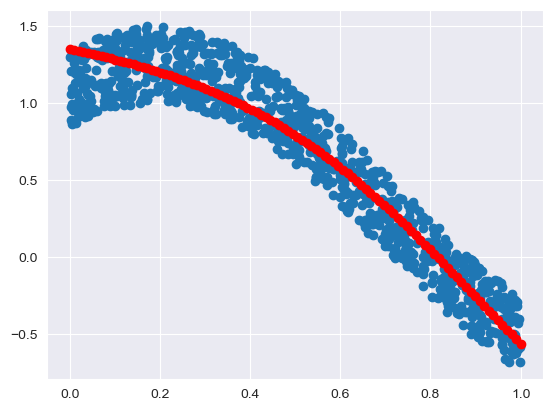

In [33]:
x_ = torch.linspace(0, 1, 100).reshape(-1, 1)
model.eval()
with torch.no_grad():
    y_ = model(x_.to(device))
plt.scatter(x, y)
plt.scatter(x_, y_.cpu(), color='r')
plt.show()

# Classification

In [34]:
N = 100
x1 = torch.randn(N, 2)
x2 = torch.randn(N, 2) + torch.Tensor([3, 3])
x3 = torch.randn(N, 2) + torch.Tensor([-3, 3])

In [35]:
X = torch.cat([x1, x2, x3], dim=0)
print(X.shape)

torch.Size([300, 2])


In [36]:
N

100

In [37]:
X.shape

torch.Size([300, 2])

In [38]:
Y = torch.cat([torch.zeros(N), torch.ones(N), torch.ones(N) * 2]).long()

In [39]:
Y.shape

torch.Size([300])

In [40]:
X.shape[1]

2

In [41]:
len(Y.unique())

3

In [42]:
# [2] 32 16 [3]
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 3)
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

In [43]:
model = Classifier()

In [44]:
device = 'cpu' 

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

model.train()
for epoch in range(5000):
    y_ = model(X.to(device))
    loss = criterion(y_, Y.to(device))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'{epoch}: {loss.item()}')

0: 1.0962780714035034
100: 1.0864685773849487
200: 1.073652982711792
300: 1.0528258085250854
400: 1.0186954736709595
500: 0.9697952270507812
600: 0.9159489870071411
700: 0.8700368404388428
800: 0.834473729133606
900: 0.80572909116745
1000: 0.7807799577713013
1100: 0.7583330869674683
1200: 0.738203763961792
1300: 0.7205551862716675
1400: 0.7054455280303955
1500: 0.6927183866500854
1600: 0.6820763945579529
1700: 0.6731799840927124
1800: 0.6657096743583679
1900: 0.6593928933143616
2000: 0.6540064811706543
2100: 0.6493728756904602
2200: 0.6453515291213989
2300: 0.6418315172195435
2400: 0.638725221157074
2500: 0.6359625458717346
2600: 0.6334877014160156
2700: 0.6312552690505981
2800: 0.6292287111282349
2900: 0.6273775696754456
3000: 0.6256773471832275
3100: 0.624107301235199
3200: 0.6226503252983093
3300: 0.6212921738624573
3400: 0.6200206279754639
3500: 0.6188253164291382
3600: 0.6176978349685669
3700: 0.6166306734085083
3800: 0.6156173944473267
3900: 0.6146530508995056
4000: 0.61373275518

In [45]:
model.eval()
with torch.no_grad():
    y_ = model(X.to(device))
acc = torch.sum(Y == y_.argmax(dim=1).cpu()) / len(Y)
print(acc.item())

0.9566666483879089


In [46]:
from sklearn.datasets import load_iris
import numpy as np
df = load_iris(as_frame=True)

In [47]:
itrain = np.r_[0:25, 50:75, 100:125]
itest = np.r_[25:50, 75:100, 125:150]
xtrain = df['data'].iloc[itrain].values
xtest = df['data'].iloc[itest].values
ytrain = df['target'].iloc[itrain].values
ytest = df['target'].iloc[itest].values

In [48]:
xtrain.shape

(75, 4)

In [49]:
len(np.unique(ytrain))

3

In [50]:
# [4] 128 [3]
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 3)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.softmax(self.fc2(x), dim=1)

In [51]:
xtrain_ = torch.tensor(xtrain, dtype=torch.float32)

In [52]:
xtest_ = torch.tensor(xtrain, dtype=torch.float32)

In [53]:
ytrain_ = torch.tensor(ytrain, dtype=torch.long)

In [54]:
ytest_ = torch.tensor(ytrain, dtype=torch.long)

In [55]:
model = Classifier()

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(5000):
    y_ = model(xtrain_.to(device))
    loss = criterion(y_, ytrain_.to(device))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'{epoch}: {loss.item()}')

0: 1.0651081800460815
100: 0.5664313435554504
200: 0.5583658218383789
300: 0.554806649684906
400: 0.5532849431037903
500: 0.5525690317153931
600: 0.5521917343139648
700: 0.5519752502441406
800: 0.5518394708633423
900: 0.551749050617218
1000: 0.5516859889030457
1100: 0.5516402721405029
1200: 0.551605761051178
1300: 0.5515794157981873
1400: 0.551558792591095
1500: 0.551542341709137
1600: 0.5515291094779968
1700: 0.5515182018280029
1800: 0.5515091419219971
1900: 0.5515015721321106
2000: 0.5514951944351196
2100: 0.5514897704124451
2200: 0.5514850616455078
2300: 0.5514808893203735
2400: 0.5514774322509766
2500: 0.5514742732048035
2600: 0.5514715313911438
2700: 0.5514691472053528
2800: 0.5514670014381409
2900: 0.5514650344848633
3000: 0.5514634251594543
3100: 0.5514618158340454
3200: 0.5514604449272156
3300: 0.5514592528343201
3400: 0.5514581203460693
3500: 0.5514571070671082
3600: 0.551456093788147
3700: 0.5514553189277649
3800: 0.5514545440673828
3900: 0.5514538288116455
4000: 0.5514531731

In [57]:
model.eval()
with torch.no_grad():
    y_ = model(xtest_.to(device))
acc = torch.sum(ytest_ == y_.argmax(dim=1).cpu()) / len(y_)
print(acc.item())

1.0


In [58]:
torch.save(model.state_dict(), 'model.pth')

In [59]:
model.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-1.8646e-01,  3.9426e-02, -1.6894e-01, -3.0254e-01],
                      [ 1.6604e-01, -5.0392e-01,  7.8137e-01,  3.7131e-01],
                      [ 5.1814e-01,  5.8182e-01, -5.2006e-01, -5.0167e-01],
                      [-6.0775e-02, -1.9516e-01,  8.5583e-01,  1.1312e+00],
                      [-1.3746e-01, -1.8188e-01, -3.0433e-01,  3.7280e-01],
                      [-2.8783e-01, -4.1461e-01,  2.4520e-01, -4.9663e-01],
                      [ 3.6515e-02, -7.0098e-01,  7.1797e-01,  1.2162e+00],
                      [-4.0080e-01, -3.3138e-01,  2.3158e-01, -3.0942e-01],
                      [-4.0610e-01, -3.3570e-01,  7.6749e-01,  7.1367e-01],
                      [ 2.5874e-01, -5.8939e-01,  8.8091e-01,  7.3089e-01],
                      [-3.5707e-01,  1.0069e-01,  7.3149e-02,  1.6971e+00],
                      [ 4.7877e-01, -8.2362e-01,  6.8760e-01,  2.4258e-01],
                      [ 4.8525e-01,  7.1467e-01, -6.2186e-01

In [60]:
df['data'].columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

In [61]:
df['data'].max()

sepal length (cm)    7.9
sepal width (cm)     4.4
petal length (cm)    6.9
petal width (cm)     2.5
dtype: float64

In [62]:
import seaborn as sns

In [63]:
df = sns.load_dataset('titanic')
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [64]:
df.nunique()

survived         2
pclass           3
sex              2
age             88
sibsp            7
parch            7
fare           248
embarked         3
class            3
who              3
adult_male       2
deck             7
embark_town      3
alive            2
alone            2
dtype: int64

In [65]:
df = df.drop(columns=['class', 'adult_male', 'deck', 'embark_town', 'alive', 'alone'])

In [66]:
import pandas as pd

In [67]:
df = pd.get_dummies(df, dtype=float)

In [68]:
df

,survived,pclass,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,who_child,who_man,who_woman
0,0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
887,1,1,19.0,0,0,30.0000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
888,0,3,NaN,1,2,23.4500,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
889,1,1,26.0,0,0,30.0000,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [69]:
df = df.drop(columns=['sex_female'])

In [70]:
df

,survived,pclass,age,sibsp,parch,fare,sex_male,embarked_C,embarked_Q,embarked_S,who_child,who_man,who_woman
0,0,3,22.0,1,0,7.2500,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,1,38.0,1,0,71.2833,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,3,26.0,0,0,7.9250,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,1,35.0,1,0,53.1000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0,3,35.0,0,0,8.0500,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.0,0,0,13.0000,1.0,0.0,0.0,1.0,0.0,1.0,0.0
887,1,1,19.0,0,0,30.0000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
888,0,3,NaN,1,2,23.4500,0.0,0.0,0.0,1.0,0.0,0.0,1.0
889,1,1,26.0,0,0,30.0000,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [71]:
df = df.dropna()

In [72]:
X = df.iloc[:, 1:]
Y = df.iloc[:, 0]

In [73]:
X

,pclass,age,sibsp,parch,fare,sex_male,embarked_C,embarked_Q,embarked_S,who_child,who_man,who_woman
0,3,22.0,1,0,7.2500,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1,38.0,1,0,71.2833,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,3,26.0,0,0,7.9250,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,35.0,1,0,53.1000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,3,35.0,0,0,8.0500,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
885,3,39.0,0,5,29.1250,0.0,0.0,1.0,0.0,0.0,0.0,1.0
886,2,27.0,0,0,13.0000,1.0,0.0,0.0,1.0,0.0,1.0,0.0
887,1,19.0,0,0,30.0000,0.0,0.0,0.0,1.0,0.0,0.0,1.0
889,1,26.0,0,0,30.0000,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [74]:
Y

0      0
1      1
2      1
3      1
4      0
      ..
885    0
886    0
887    1
889    1
890    0
Name: survived, Length: 714, dtype: int64

In [75]:
from sklearn.model_selection import train_test_split

In [76]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2)

In [77]:
xtrain = torch.tensor(xtrain.values, dtype=torch.float32)
xtest = torch.tensor(xtest.values, dtype=torch.float32)
ytrain = torch.tensor(ytrain.values, dtype=torch.float32)
ytest = torch.tensor(ytest.values, dtype=torch.float32)
ytrain = ytrain.reshape(-1, 1)
ytest = ytest.reshape(-1, 1)

In [78]:
xtrain.shape

torch.Size([571, 12])

In [79]:
ytrain.unique()

tensor([0., 1.])

In [80]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(12, 128)
        self.fc2 = nn.Linear(128, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

In [81]:
model = Classifier()

In [82]:
ytrain.shape

torch.Size([571, 1])

In [83]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(5000):
    y_ = model(xtrain.to(device))
    loss = criterion(y_, ytrain.to(device))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'{epoch}: {loss.item()}')

0: 1.5834019184112549
100: 0.4095386862754822
200: 0.3813653588294983
300: 0.35147446393966675
400: 0.33771416544914246
500: 0.3006719946861267
600: 0.27877387404441833
700: 0.2648756802082062
800: 0.25234776735305786
900: 0.24125812947750092
1000: 0.23071400821208954
1100: 0.22668874263763428
1200: 0.2137288749217987
1300: 0.20809544622898102
1400: 0.20269513130187988
1500: 0.19682997465133667
1600: 0.1920379400253296
1700: 0.18770955502986908
1800: 0.20197826623916626
1900: 0.18713736534118652
2000: 0.18227215111255646
2100: 0.17912495136260986
2200: 0.1759883016347885
2300: 0.17314180731773376
2400: 0.17301517724990845
2500: 0.16877050697803497
2600: 0.16631557047367096
2700: 0.16475950181484222
2800: 0.16641978919506073
2900: 0.1634591668844223
3000: 0.1664542555809021
3100: 0.6749376654624939
3200: 0.16885896027088165
3300: 0.16077229380607605
3400: 0.159812331199646
3500: 0.15887142717838287
3600: 0.1584760993719101
3700: 0.15735691785812378
3800: 0.1571117490530014
3900: 0.15641

In [84]:
model.eval()
with torch.no_grad():
    y_ = model(xtest.to(device))
acc = torch.sum(ytest == y_.round().cpu()) / len(y_)
print(acc.item())

0.7832167744636536
